# Alpha Factor Aggregation

by Maxwell Margenot and Delaney Granizo-Mackenzie

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---

Once you have decided what alpha factors you are going to include in your long-short equity algorithm, you need to think of some way to combine them. This can be another way to add flavor to worn-out and familiar factors as combining factors in a novel way could lend a new perspective on the relative movements in the market that you couldn't access from the factors you chose individually.

## Calculating Factor Returns

In [3]:
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.filters import Q500US
from quantopian.pipeline.factors import CustomFactor, Returns, AverageDollarVolume
from quantopian.pipeline.data import morningstar

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [4]:
bs = morningstar.balance_sheet
cfs = morningstar.cash_flow_statement
is_ = morningstar.income_statement
or_ = morningstar.operation_ratios
er = morningstar.earnings_report
v = morningstar.valuation
vr = morningstar.valuation_ratios

universe = Q500US()

Define some factors

In [8]:
class Momentum(CustomFactor):
    # Momentum Factor
    # Enhanced Price Momentum
    # (12-month momentum - Momentum over last month)/ sigma of past six months
    inputs = [USEquityPricing.close,
              Returns(window_length=126)]
    window_length = 252

    def compute(self, today, assets, out, prices, returns):
        out[:] = ((prices[-21] - prices[-252])/prices[-252] -
                  (prices[-1] - prices[-21])/prices[-21]) / np.nanstd(returns, axis=0)

class Volatility(CustomFactor):
    # Volatility Factor
    # Volatility of price over last 90 days
    inputs = [USEquityPricing.close]
    window_length = 90

    def compute(self, today, assets, out, prices):
        out[:] = np.nanstd(prices, axis=0)

Let's grab some data

In [19]:
NUM_LONG_POSITIONS = 100
NUM_SHORT_POSITIONS = 100

value = cfs.free_cash_flow.latest/v.market_cap.latest
momentum = Momentum(mask=universe)
volatility = Volatility(mask=universe)

value_rank  = value.rank()
momentum_rank = momentum.rank()
volatility_rank = volatility.rank()

pipe = Pipeline(
        columns = {
        'Value' : value,
        'Momentum' : momentum,
        'Volatility' : volatility,
        'returns' : Returns(inputs=[USEquityPricing.close], window_length=2),
        'highval' : value_rank.top(NUM_LONG_POSITIONS),
        'lowval' : value_rank.bottom(NUM_SHORT_POSITIONS),
        'highmomentum' : momentum_rank.top(NUM_LONG_POSITIONS),
        'lowmomentum' : momentum_rank.bottom(NUM_SHORT_POSITIONS),
        'highvol' : volatility_rank.top(NUM_LONG_POSITIONS),
        'lowvol' : volatility_rank.bottom(NUM_SHORT_POSITIONS)
    },
    screen = universe)

In [5]:
results = run_pipeline(pipe, '2016-01-01', '2017-01-01')
results.head()

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


Momentum     Value  Volatility  \
2016-01-04 00:00:00+00:00 Equity(2 [ARNC])  -3.906100  0.011648    0.609595   
                          Equity(24 [AAPL])  1.119194  0.016407    4.228688   
                          Equity(62 [ABT])   0.381835  0.011610    1.804147   
                          Equity(67 [ADSK])  1.019880  0.004877    7.267074   
                          Equity(76 [TAP])   2.259854  0.011173    8.992524   

                                            highmomentum highval highvol  \
2016-01-04 00:00:00+00:00 Equity(2 [ARNC])         False   False   False   
                          Equity(24 [AAPL])        False   False   False   
                          Equity(62 [ABT])         False   False   False   
                          Equity(67 [ADSK])        False   False    True   
                          Equity(76 [TAP])          True   False    True   

                                            lowmomentum lowval lowvol  \
2016-01-04 00:00:00+00:00 Equity(2 [ARNC])         True  False   True   
                          Equity(24 [AAPL])       False  False  False   
                          Equity(62 [ABT])        False  False  False   
                          Equity(67 [ADSK])       False  False  False   
                          Equity(76 [TAP])        False  False  False   

                                              returns  
2016-01-04 00:00:00+00:00 Equity(2 [ARNC])  -0.010040  
                          Equity(24 [AAPL]) -0.019474  
                          Equity(62 [ABT])  -0.007733  
                          Equity(67 [ADSK]) -0.021365  
                          Equity(76 [TAP])  -0.006558

In [6]:
momentum_returns = results[results.highmomentum]['returns'].groupby(level=0).mean()- \
                    results[results.lowmomentum]['returns'].groupby(level=0).mean()
value_returns = results[results.highval]['returns'].groupby(level=0).mean()- \
                    -results[results.lowval]['returns'].groupby(level=0).fillna(0).mean()
value_returns = value_returns.reindex(momentum_returns.index, fill_value=0)
volatility_returns = results[results.highvol]['returns'].groupby(level=0).mean()- \
                    results[results.lowvol]['returns'].groupby(level=0).mean()
factor_returns = np.array([value_returns.mean(), momentum_returns.mean(), volatility_returns.mean()])

In [7]:
print 'Momentum return: ', momentum_returns.mean(), ' vol: ', momentum_returns.std()
print 'Value return: ', value_returns.mean(), ' vol: ', value_returns.std()
print 'Volatility return: ', volatility_returns.mean(), ' vol: ', volatility_returns.std()

Momentum return:  -0.00417822486146  vol:  0.0124876626794
Value return:  0.00271923272791  vol:  0.0398517990159
Volatility return:  -0.0007595284403  vol:  0.00574372035703


In [8]:
factor_portfolio_weights = np.array([1/3., 1/3., 1/3.])
factor_portfolio_return = np.sum(factor_returns * factor_portfolio_weights)
factor_portfolio_covariance = np.cov([momentum_returns.values, value_returns.values, volatility_returns.values])
factor_portfolio_volatility = factor_portfolio_weights.dot(factor_portfolio_covariance.dot(factor_portfolio_weights.T))

In [9]:
print "Portfolio return: ", factor_portfolio_return, ' vol: ', factor_portfolio_volatility

Portfolio return:  -0.000739506857949  vol:  0.000139228543951


## Normalizing Factors

When we want to aggregate factors together, we need to consider their individual scales. Certain calculations of factors may simply yield larger values and if we want to combine many different factors that work on different scales, it helps to normalize them so that they don't unduly influence our composite factor.

Take, for example, our above defined Value and Momentum factors. Let's have a look at their values.

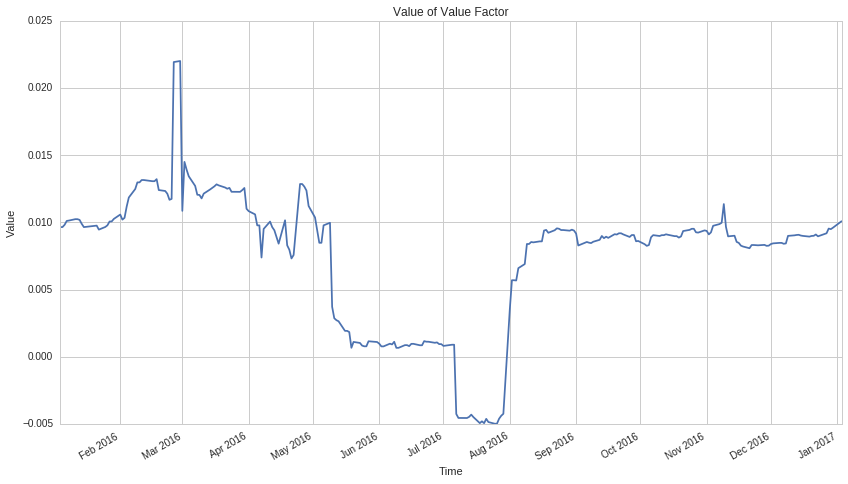

In [10]:
# Here's an example of a calculation that is far overweighed by one factor
value_factor = results['Value']
value_factor_daily_mean = value_factor.groupby(level=0).mean()
value_factor_daily_mean.plot();
plt.title("Value of Value Factor")
plt.xlabel("Time")
plt.ylabel("Value");
# Toy Example, take Market Cap and add it to something basic or something.

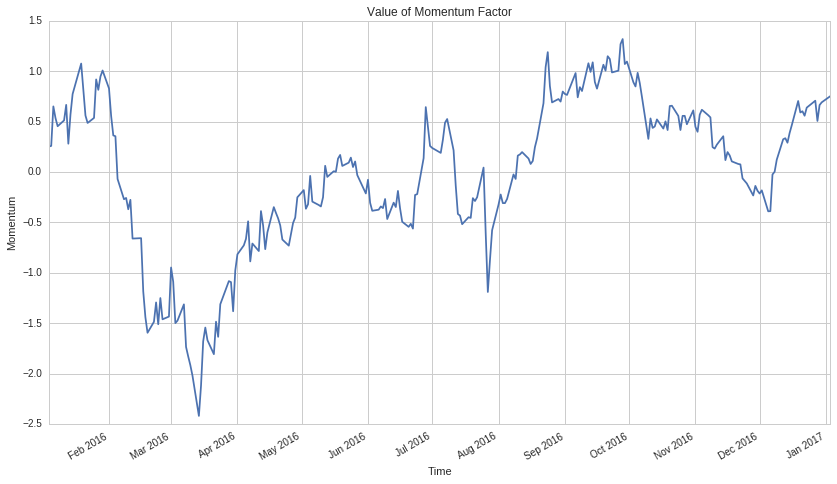

In [11]:
momentum_factor = results['Momentum']
momentum_factor_daily_mean = momentum_factor.groupby(level=0).mean()
momentum_factor_daily_mean.plot()
plt.title("Value of Momentum Factor")
plt.xlabel("Time")
plt.ylabel("Momentum");

These two factors are clearly on entirely different scales. If we wanted to combine these factors into one by adding their values, the momentum factor would entirely dominate the value factor, giving us a portfolio that is mostly built on momentum rather than built on both momentum and value equally.

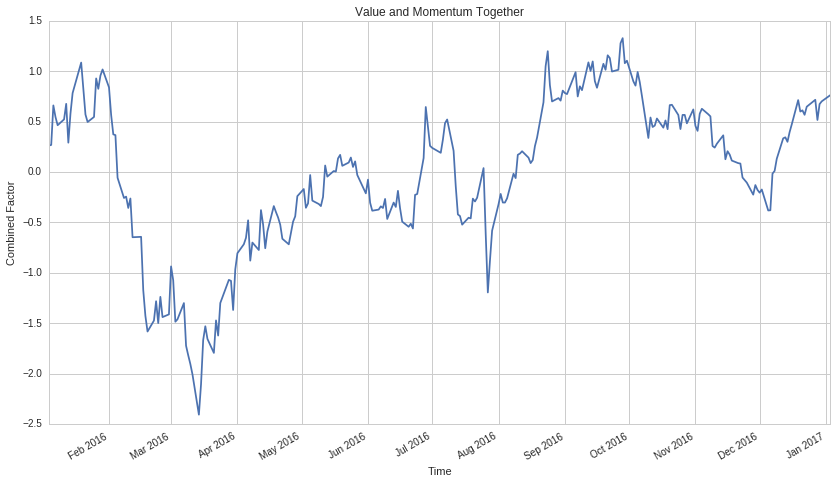

In [12]:
value_and_momentum_factor = value_factor + momentum_factor
v_and_m_daily_mean = value_and_momentum_factor.groupby(level=0).mean()
v_and_m_daily_mean.plot()
plt.title("Value and Momentum Together")
plt.xlabel("Time")
plt.ylabel("Combined Factor");

## Static Weighting

Definition of a static weighting

moving average?

EWMA?

kalman filter of some sort?

The values of the Value factor are smaller than the values of the Momentum factor by a couple magnitudes.

In [13]:
print "Ratio of Value to Momentum: ", (value_factor_daily_mean/momentum_factor_daily_mean).mean()

Ratio of Value to Momentum:  0.0159288607032


However if we normalize each factor individually, it maintains the ranking scheme (and the baskets that we want to look at) while equalizing the influence of the individual factors.

In [14]:
normalized_momentum = (momentum_factor_daily_mean - momentum_factor_daily_mean.mean())\
                        /momentum_factor_daily_mean.std()
normalized_value = (value_factor_daily_mean - value_factor_daily_mean.mean())\
                        /value_factor_daily_mean.std()

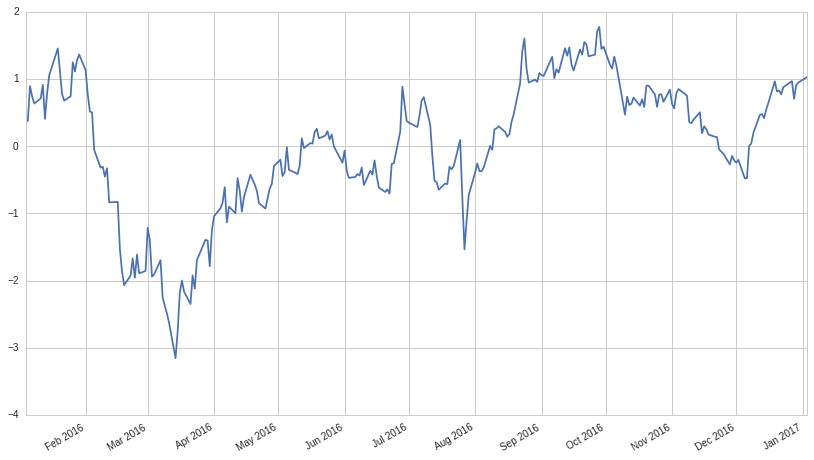

In [15]:
normalized_momentum.plot();

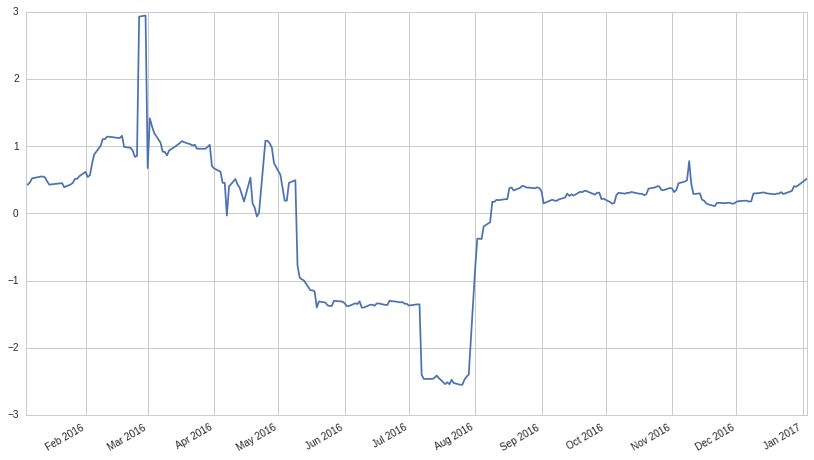

In [16]:
normalized_value.plot();

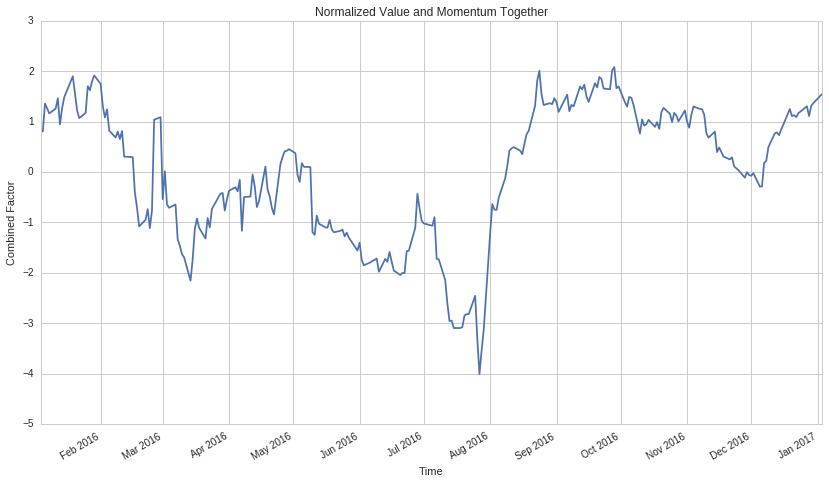

In [17]:
normalized_v_and_m = normalized_momentum + normalized_value
normalized_v_and_m.plot()
plt.title("Normalized Value and Momentum Together")
plt.xlabel("Time")
plt.ylabel("Combined Factor");

In [18]:
print "Ratio of Value to Momentum: ", (normalized_value/normalized_momentum).mean()

Ratio of Value to Momentum:  1.23729195159


Our two factors are now on the same scale after normalization.

We can think of aggregated factors made up of many smaller factors as combinations of long-short equity portfolios/assets themselves. By combining many of these assets into one factor (portfolio), we get the same effect that you get from portfolio diversification. Higher return for less volatility.

In [ ]:
# Take return streams from factors before, equal weight, show portfolio combination

# What does Static vs Dynamic weight mean?

The above combined factor is an example of a static aggregation method. We simply add the two normalized factors together so that the aggregate factor is 50% momentum, 50% value. We have selected a weighting scheme and will carry it forward without any modifications.

An alternative approach is to adjust the weighting between the underlying factors 

In [63]:
class SPYVol(CustomFactor):
    inputs = [Returns(window_length=2)]
    
    def compute(self, today, assets, out, returns):
        idx = np.where(assets == 8554) # Check the dataframe for the SID of SPY
        spy_returns = returns[:,idx]
        out[:] = np.nanstd(spy_returns)

In [64]:
short_term_spy_vol = SPYVol(window_length=21)
long_term_spy_vol = SPYVol(window_length=63)
tradeoff_factor = Momentum().zscore()* (short_term_spy_vol/long_term_spy_vol) + \
            Volatility().zscore() * (1-(short_term_spy_vol/long_term_spy_vol))

We use the same universe as before and add our tradeoff factor to the pipeline.

In [57]:
tradeoff_rank = tradeoff_factor.rank()

pipe = Pipeline(
    columns = {
        "MomentumVolSwitch":tradeoff_factor,
        'returns': Returns(inputs=[USEquityPricing.close], window_length=2),
        "hightradeoff":tradeoff_rank.top(NUM_LONG_POSITIONS),
        "lowtradeoff":tradeoff_rank.bottom(NUM_SHORT_POSITIONS)
    },
    screen=universe
)

In [58]:
tradeoff_results = run_pipeline(pipe, '2012-01-01', '2017-01-01')

In [59]:
tradeoff_results.head()

MomentumVolSwitch hightradeoff  \
2012-01-03 00:00:00+00:00 Equity(2 [ARNC])           -0.145158        False   
                          Equity(24 [AAPL])           0.654942        False   
                          Equity(62 [ABT])            1.062334        False   
                          Equity(67 [ADSK])           0.123091        False   
                          Equity(88 [ACI])           -0.307739        False   

                                            lowtradeoff   returns  
2012-01-03 00:00:00+00:00 Equity(2 [ARNC])        False  0.002317  
                          Equity(24 [AAPL])       False -0.000272  
                          Equity(62 [ABT])        False -0.002663  
                          Equity(67 [ADSK])       False -0.002303  
                          Equity(88 [ACI])        False  0.028369

In [60]:
tradeoff_returns = tradeoff_results[tradeoff_results.hightradeoff]['returns'].groupby(level=0).mean()- \
                    tradeoff_results[tradeoff_results.lowtradeoff]['returns'].groupby(level=0).mean()

In [61]:
tradeoff_returns.mean()

-0.010831010398198958

In [62]:
tradeoff_returns.std()

0.04793722976402172

## Dynamic Weighting

Definition of a dynamic weighting, using info from the environment 

OR historical information from the factors themselves

ML

Iterative model development:

get a bunch of factors, monitor them, drop them as they break and replace; no model is perfect